In [18]:
import math
from types import SimpleNamespace
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import wandb

In [7]:
# Load the CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [8]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

100%|██████████| 170M/170M [00:10<00:00, 16.4MB/s]


In [10]:
def get_dataloaders():
  return trainloader, testloader

In [13]:
INPUT_SIZE = 3 * 32 * 32
OUTPUT_SIZE = 10
HIDDEN_SIZE = 256
NUM_WORKERS = 2
CLASSES = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
DEVICE = torch.device("cuda" if torch.cuda.is_available()  else "cpu")

def get_model(dropout):
    "Simple MLP with Dropout"
    return nn.Sequential(
        nn.Conv2d(3, 6, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),

        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),


        nn.Flatten(start_dim=1),

        nn.Linear(16 * 5 * 5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    ).to(DEVICE)

In [14]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 5,
    batch_size = 128,
    lr = 1e-5,
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [19]:
def validate_model(model, valid_dl, loss_func):
    "Compute the performance of the model on the validation dataset"
    model.eval()
    val_loss = 0.0
    all_labels = []
    all_predictions = []

    with torch.inference_mode():
        for i, (images, labels) in enumerate(valid_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            # Forward pass
            outputs = model(images)
            val_loss += loss_func(outputs, labels) * labels.size(0)

            # Collect predictions and labels
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Calculate metrics
    val_accuracy = accuracy_score(all_labels, all_predictions)
    val_precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0)
    val_recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0)
    val_f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0)

    return val_loss / len(valid_dl.dataset), val_accuracy, val_precision, val_recall, val_f1

In [20]:
def train_model(config):
    "Train a model with a given config"

    wandb.init(
        project="cifar10_cnn",
        config=config,
    )

    # Get the data
    train_dl, valid_dl = get_dataloaders()
    n_steps_per_epoch = math.ceil(len(train_dl.dataset) / config.batch_size)

    # A simple CNN model
    model = get_model(config.dropout)

    # Make the loss and optimizer
    loss_func = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=config.lr)

    example_ct = 0

    for epoch in tqdm(range(config.epochs), total=config.epochs):
        model.train()

        # For training metrics
        train_labels = []
        train_predictions = []
        epoch_train_loss = 0.0

        for step, (images, labels) in enumerate(train_dl):
            images, labels = images.to(DEVICE), labels.to(DEVICE)

            outputs = model(images)
            train_loss = loss_func(outputs, labels)
            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            # Collect predictions and labels for training metrics
            _, predicted = torch.max(outputs.data, 1)
            train_labels.extend(labels.cpu().numpy())
            train_predictions.extend(predicted.cpu().numpy())
            epoch_train_loss += train_loss.item() * labels.size(0)

            example_ct += len(images)
            metrics = {
                "train/train_loss": train_loss,
                "train/epoch": epoch + 1,
                "train/example_ct": example_ct
            }
            wandb.log(metrics)

        # Calculate training metrics at the end of epoch
        train_accuracy = accuracy_score(train_labels, train_predictions)
        train_precision = precision_score(train_labels, train_predictions, average='macro', zero_division=0)
        train_recall = recall_score(train_labels, train_predictions, average='macro', zero_division=0)
        train_f1 = f1_score(train_labels, train_predictions, average='macro', zero_division=0)

        # Compute validation metrics
        val_loss, val_accuracy, val_precision, val_recall, val_f1 = validate_model(model, valid_dl, loss_func)

        # Log all metrics
        epoch_metrics = {
            "train/epoch_train_loss": epoch_train_loss / len(train_dl.dataset),
            "train/train_accuracy": train_accuracy,
            "train/train_precision": train_precision,
            "train/train_recall": train_recall,
            "train/train_f1": train_f1,
            "val/val_loss": val_loss,
            "val/val_accuracy": val_accuracy,
            "val/val_precision": val_precision,
            "val/val_recall": val_recall,
            "val/val_f1": val_f1
        }
        wandb.log(epoch_metrics)

    wandb.finish()

In [11]:
from google.colab import userdata
WANDB_API_KEY = userdata.get('WANDB_KEY')

In [ ]:
wandb.login(key=WANDB_API_KEY)

In [ ]:
train_model(config)

---

## Weights and Biases Plots (Run #1)

### Train Plots

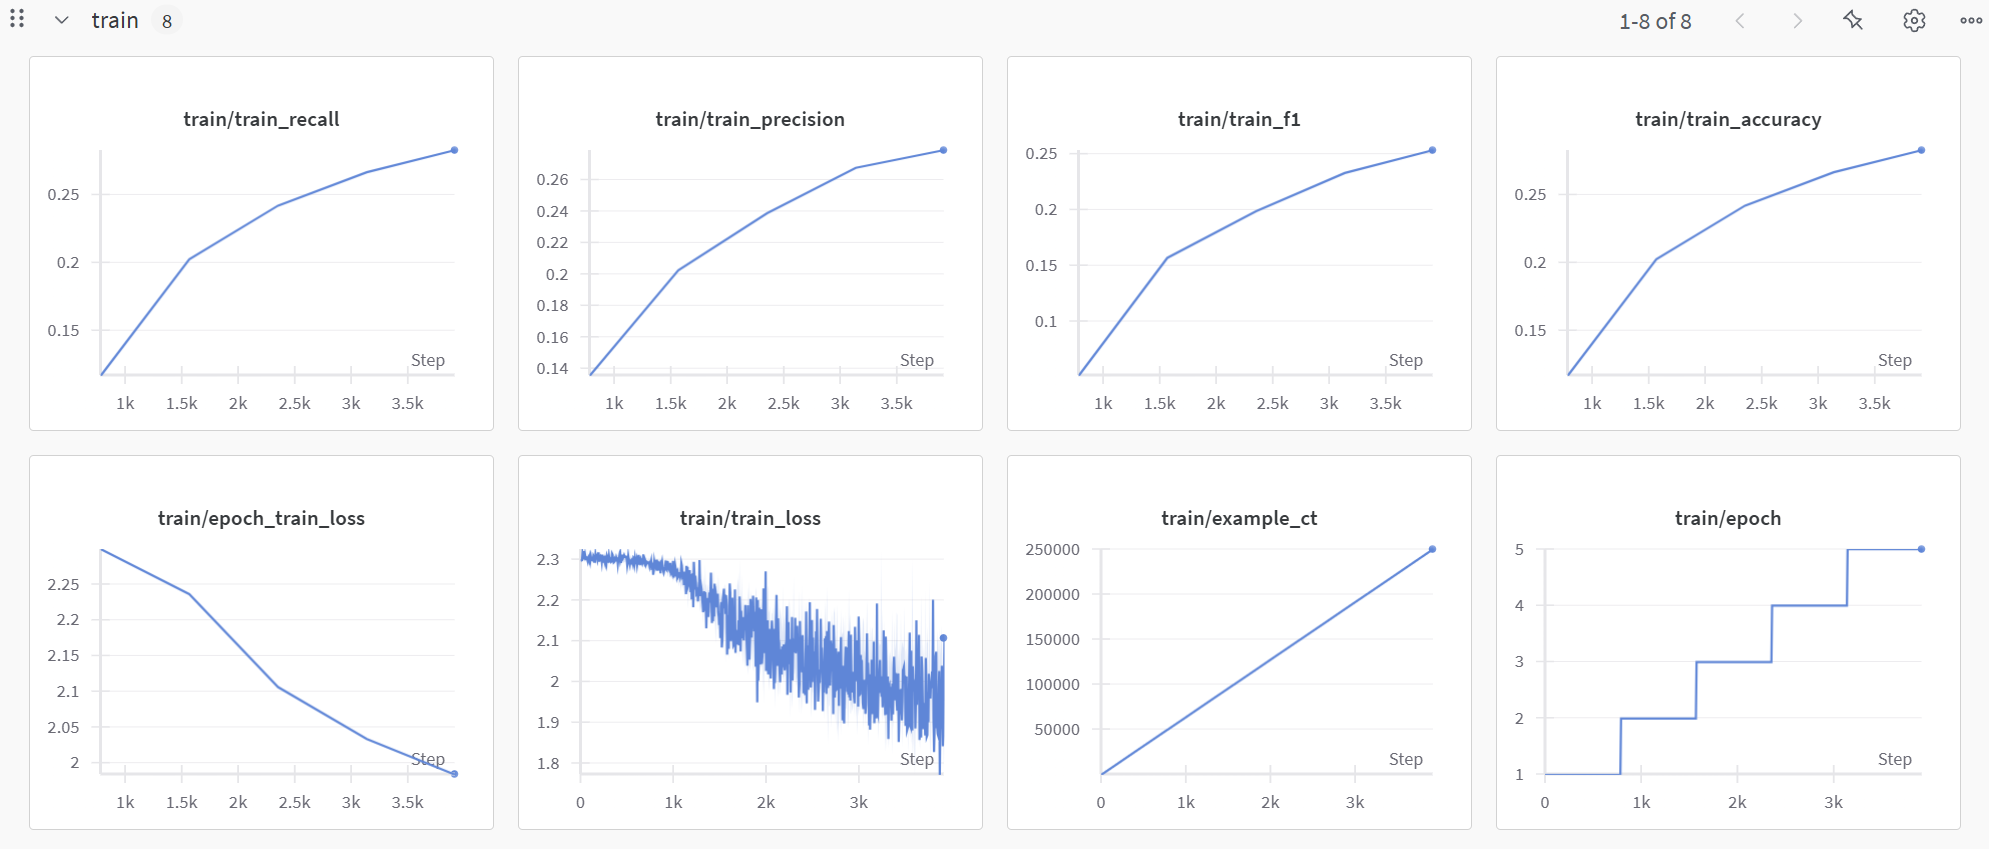


### Val Plots
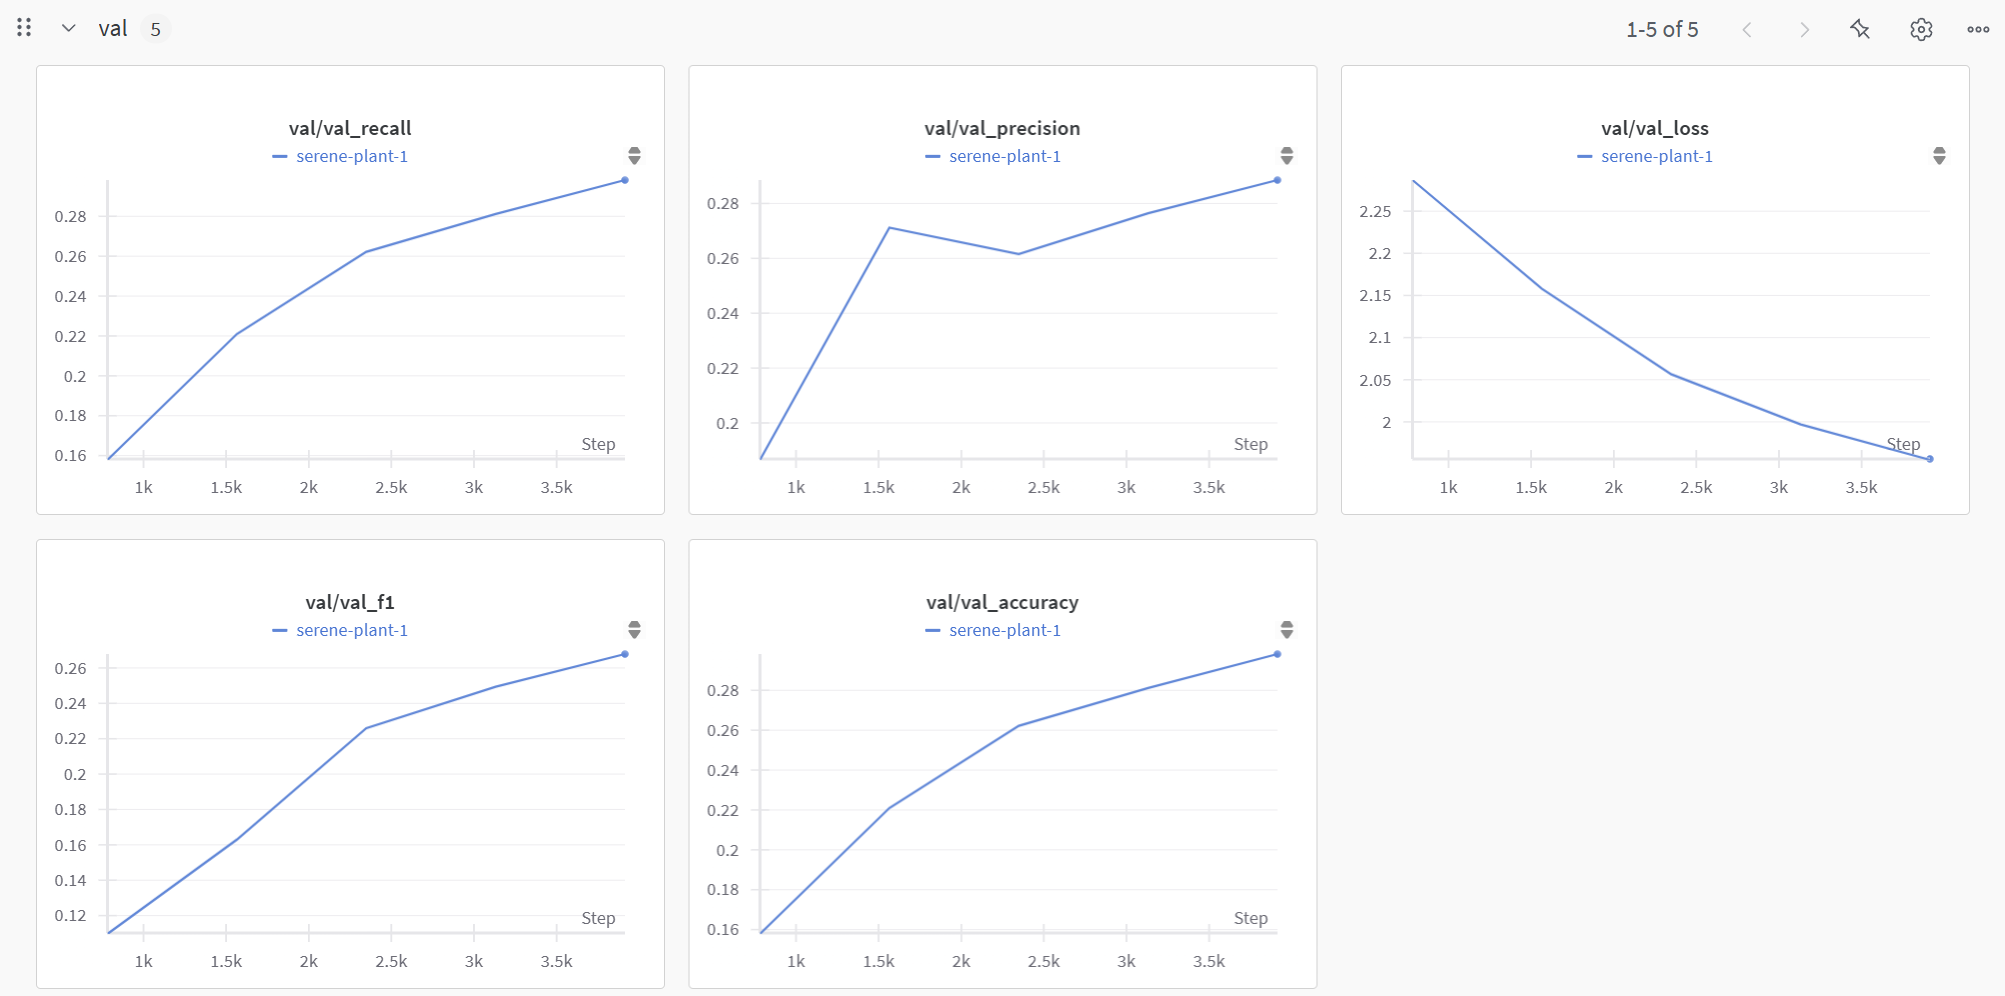

---

In [22]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 5,
    batch_size = 128,
    lr = 1e-4, # Increase Learning rate
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [ ]:
train_model(config)

## WANDB Plots (Run #2)

### Training Plots
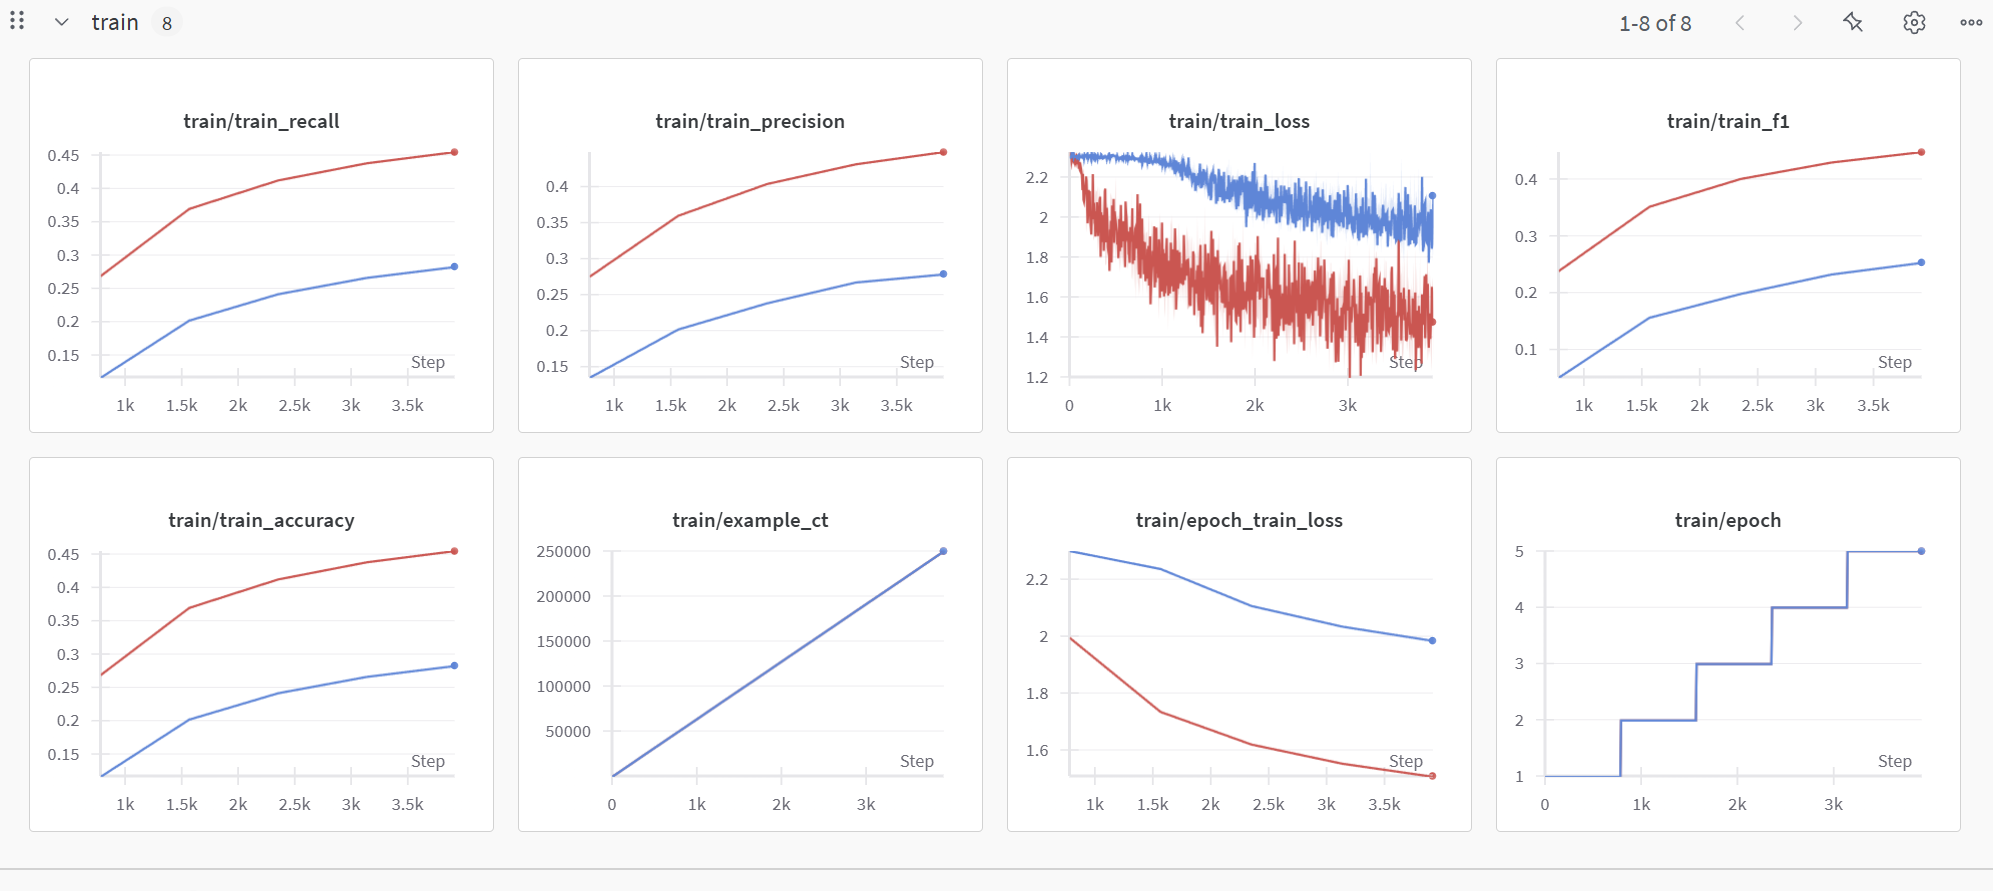

### Val Plots
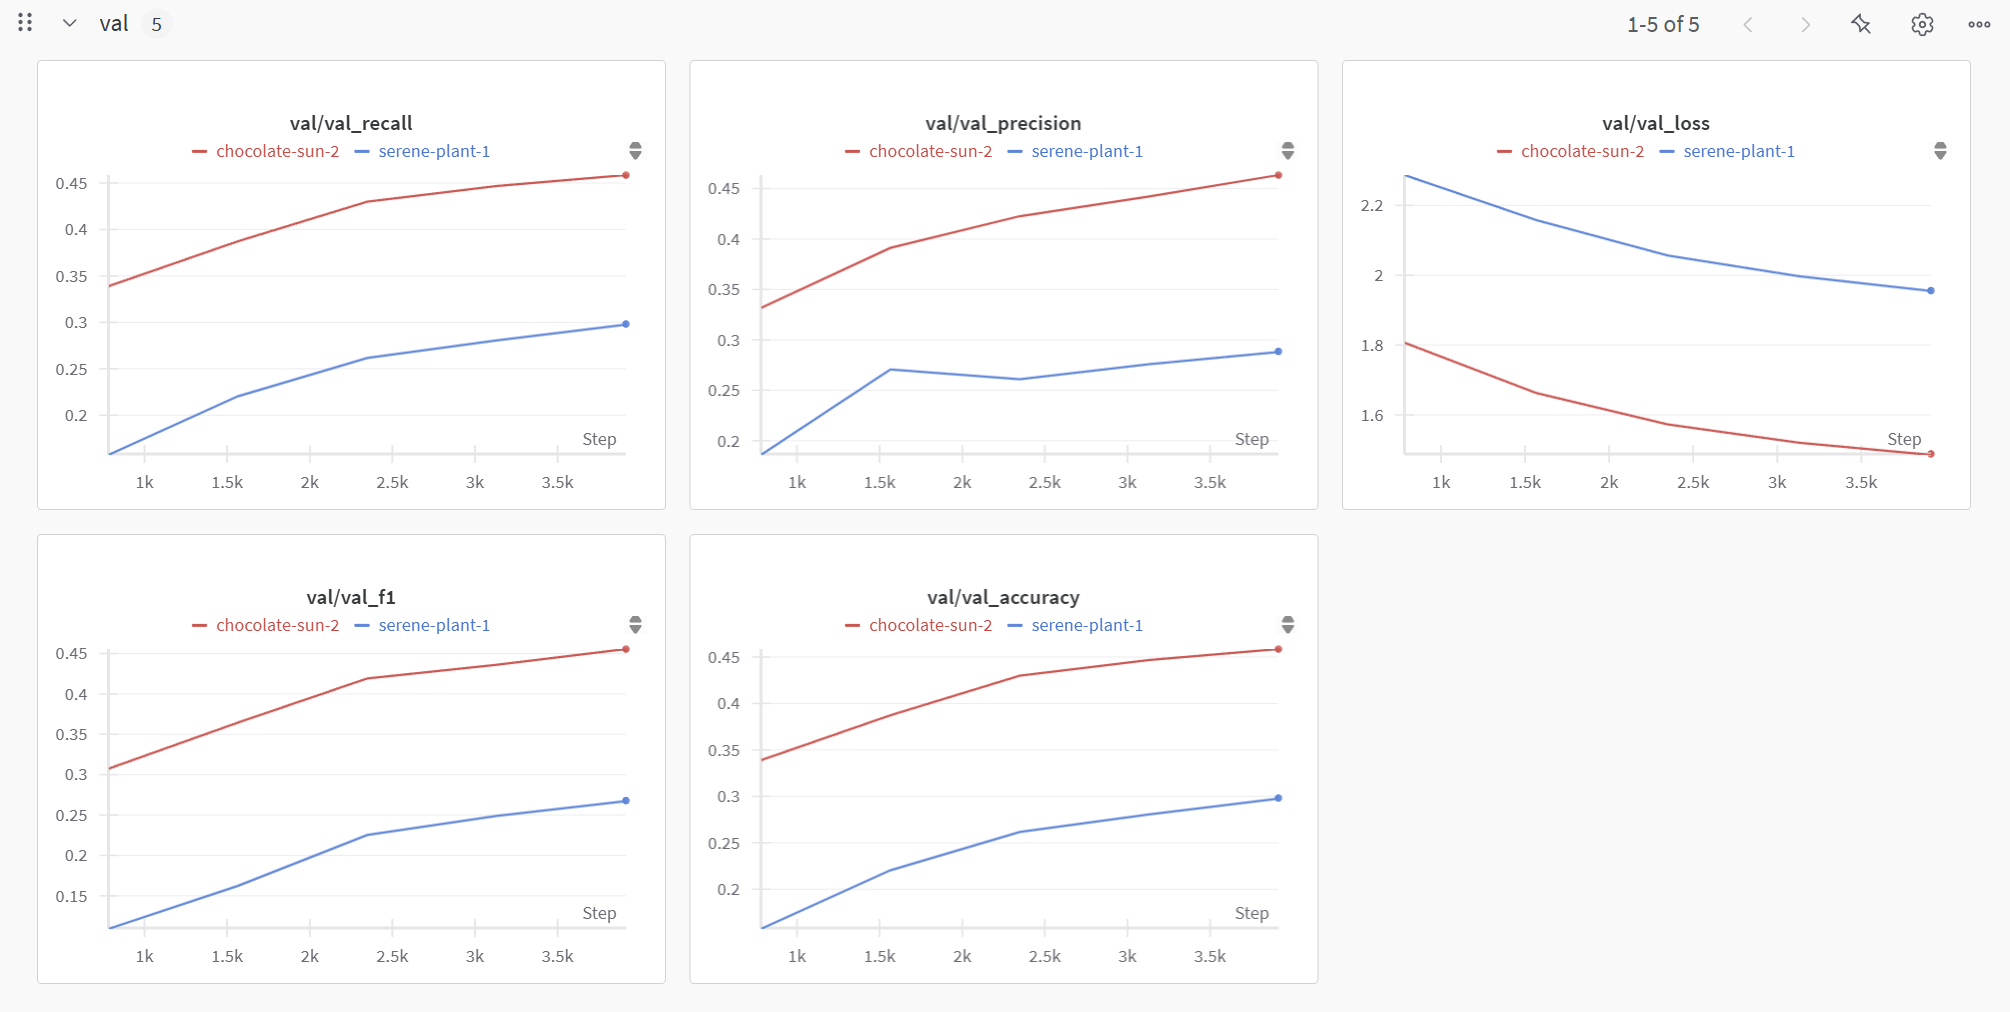

---

In [24]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 5,
    batch_size = 256, # Increse Batch Size
    lr = 1e-3, # Increase Learning Rate
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [ ]:
train_model(config)

## WANDB Plots (Run #3)

## Train Plots
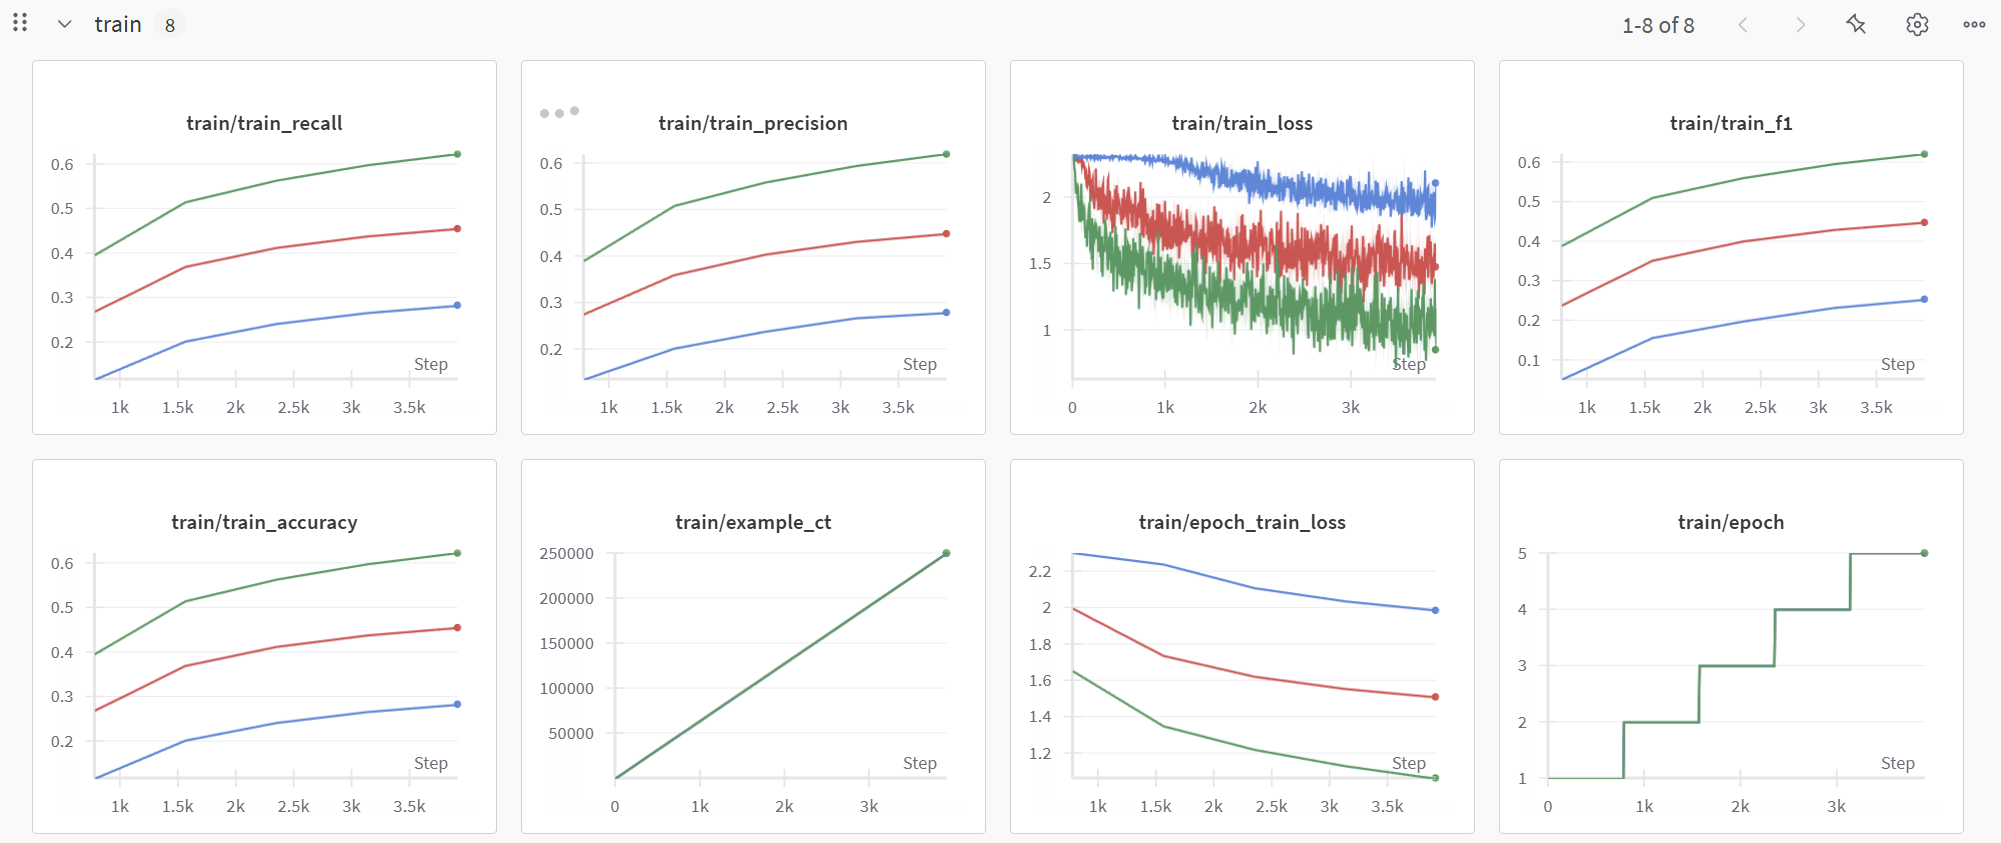

## Val Plots
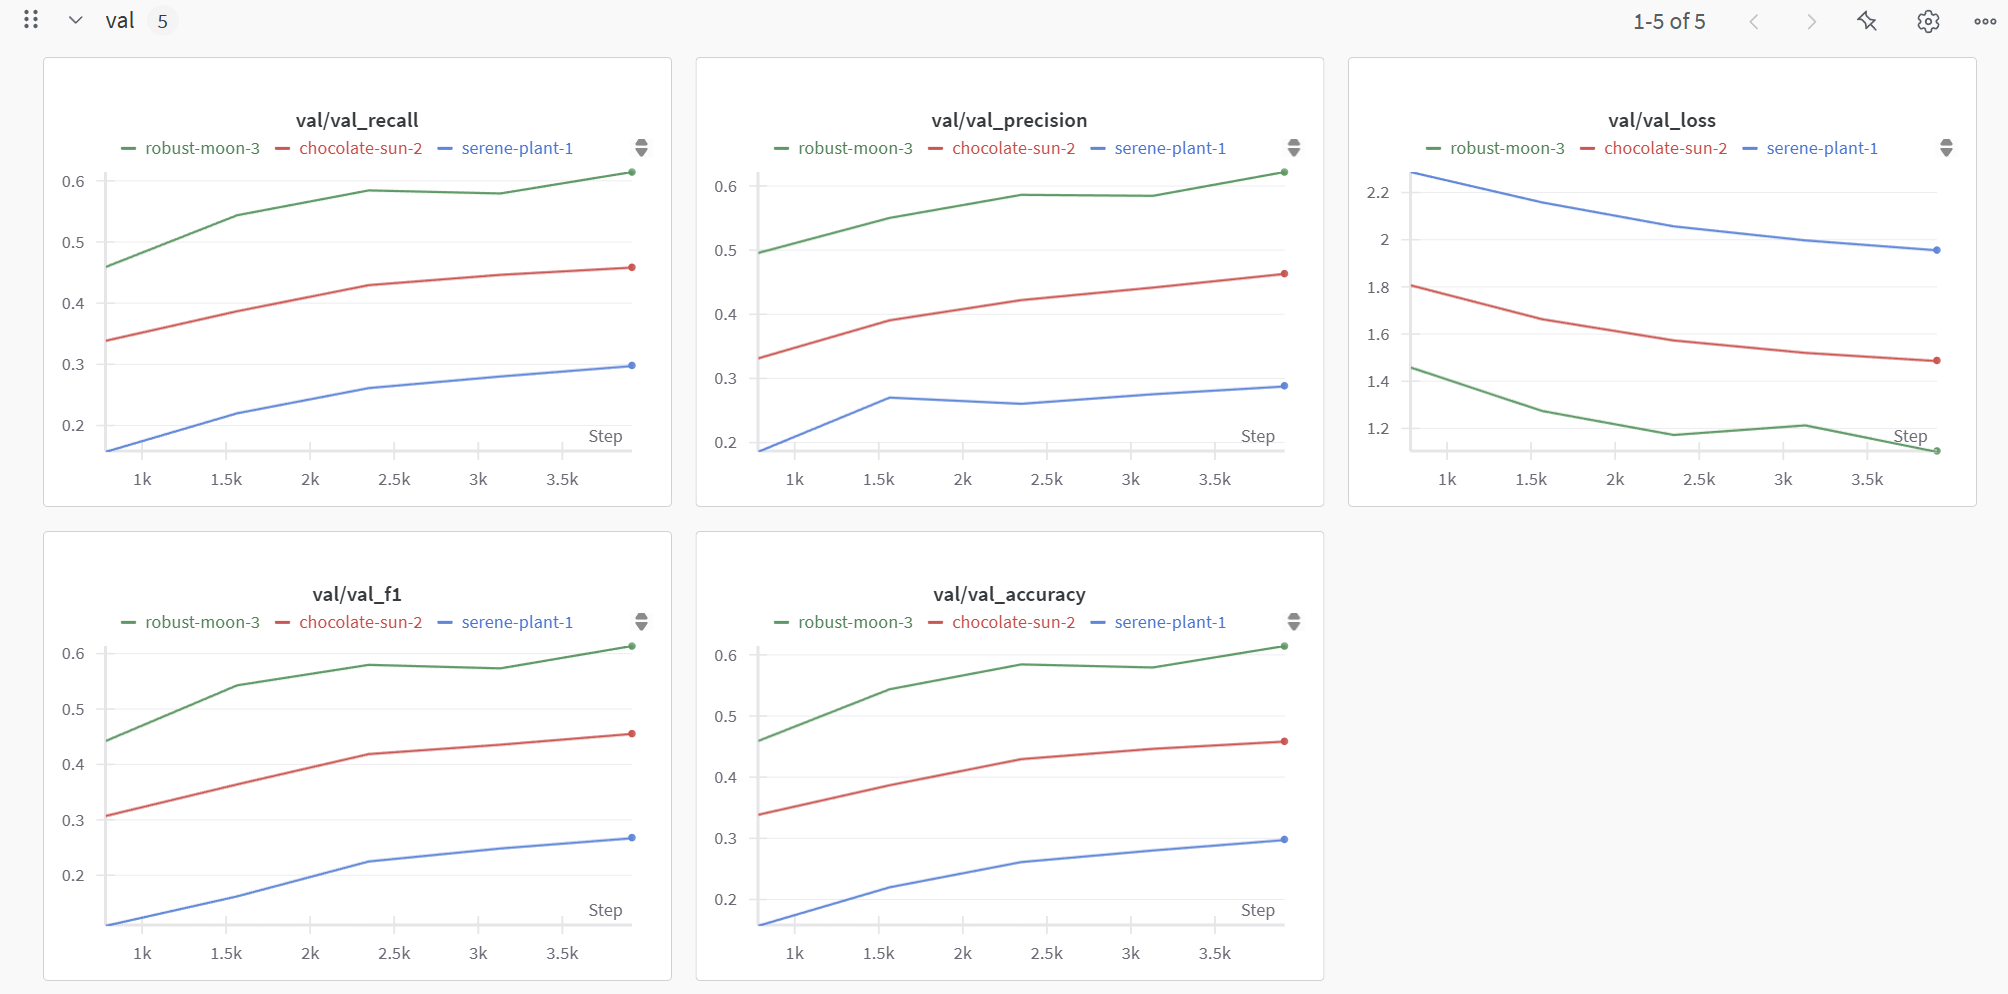

---

In [26]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 5,
    batch_size = 256,
    lr = 1e-2, # Increase Learning Rate
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [ ]:
train_model(config)

## WANDB Plots (Run #4)

## Train Plots
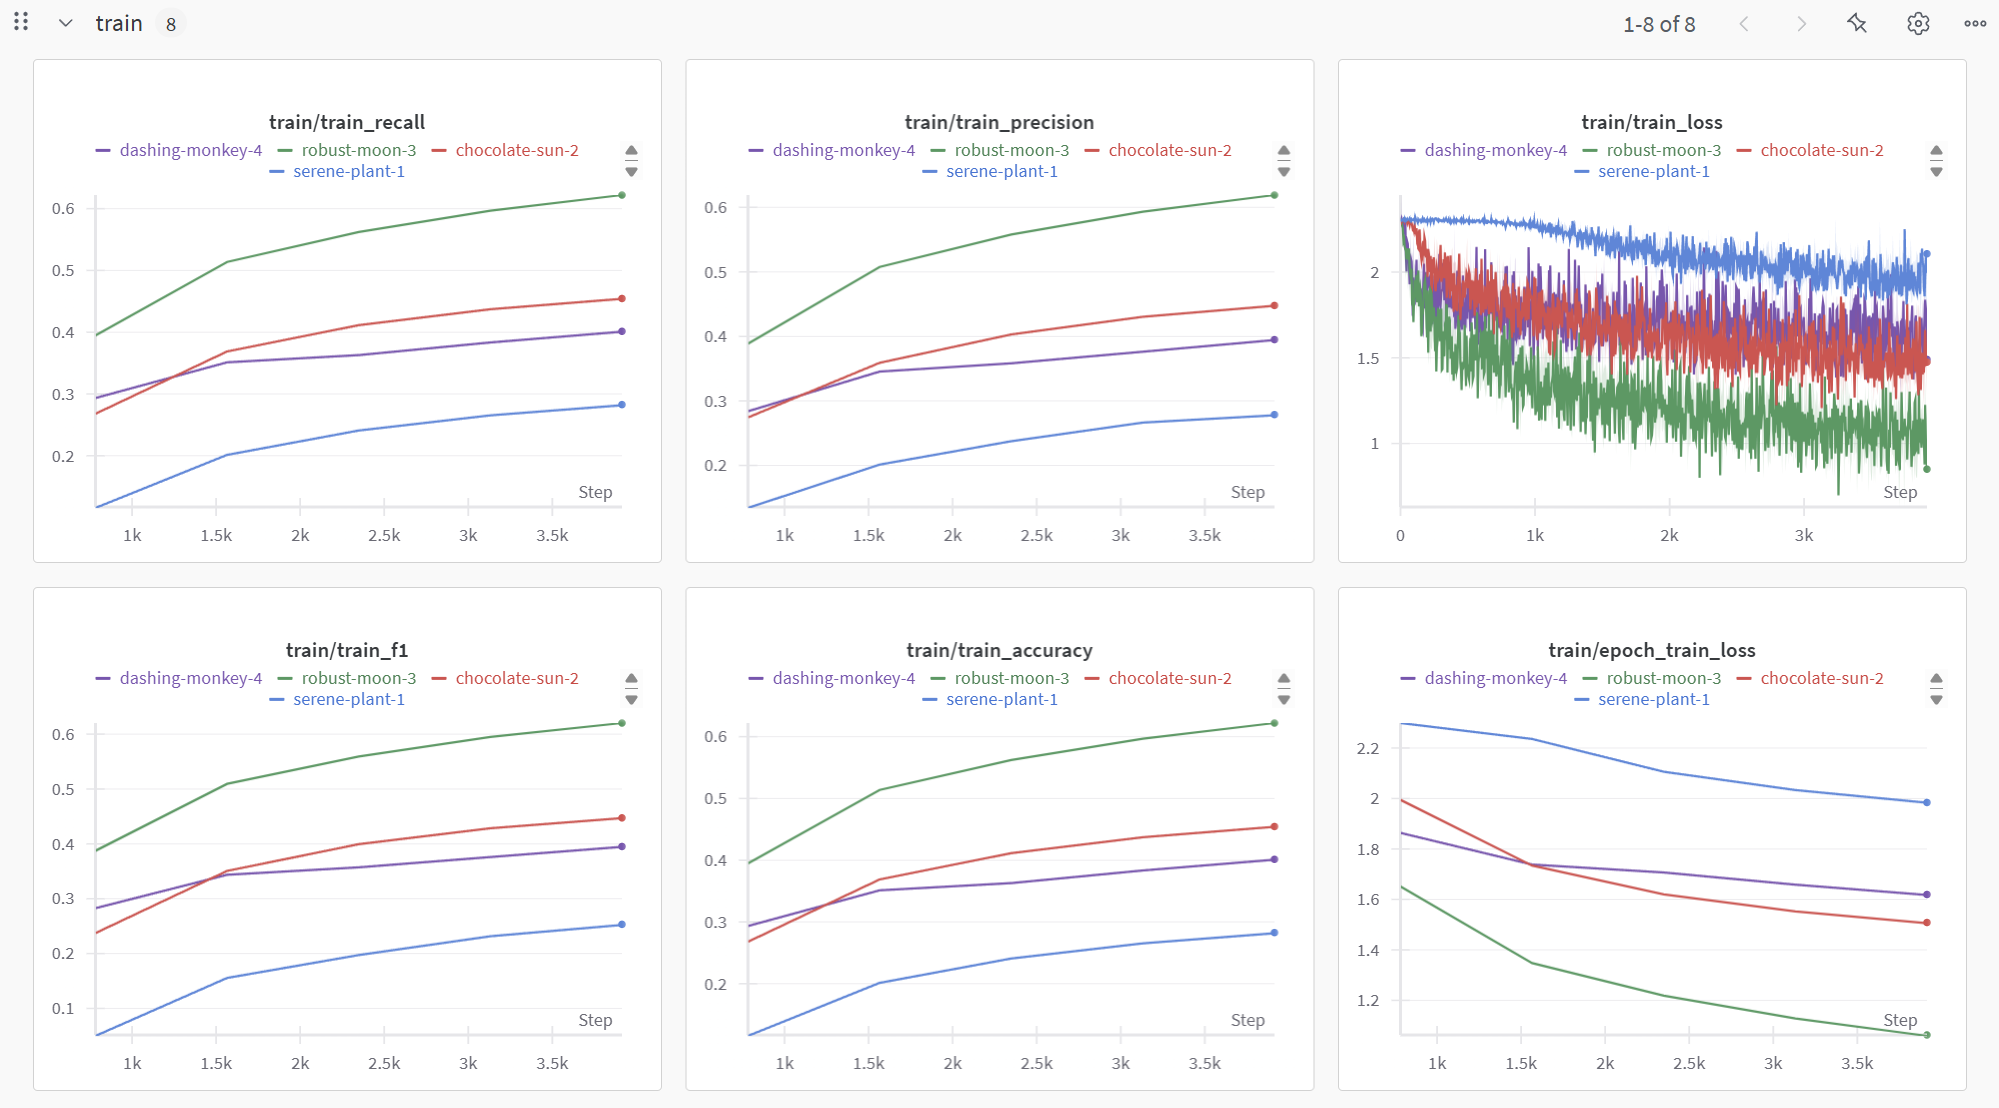

## Val Plots
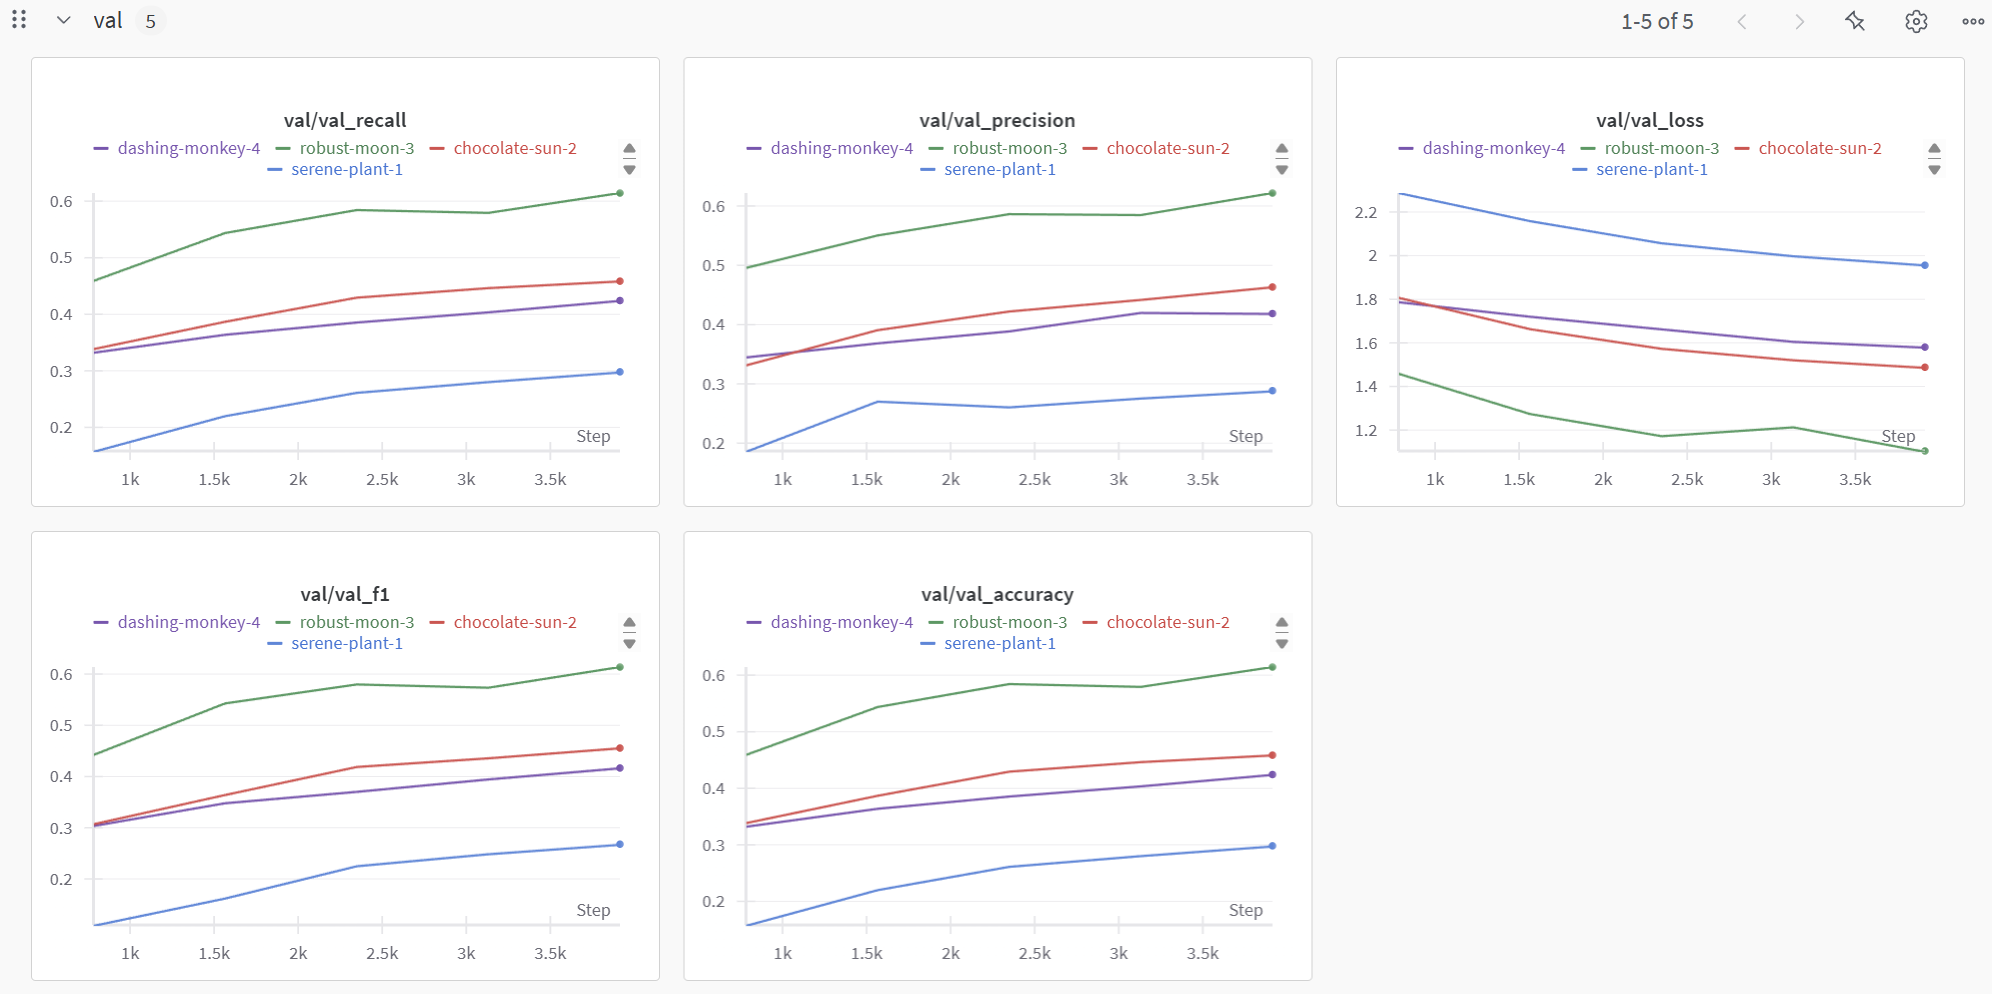

---

In [39]:
# Let's define a config object to store our hyperparameters
config = SimpleNamespace(
    epochs = 30, # Increase epoch count
    batch_size = 256,
    lr = 1e-3, # Decrease Learning Rate
    dropout = 0.5,
    slice_size = 10_000,
    valid_pct = 0.2,
)

In [ ]:
train_model(config)

## WANDB Plots (Run #5)

## Train Plots
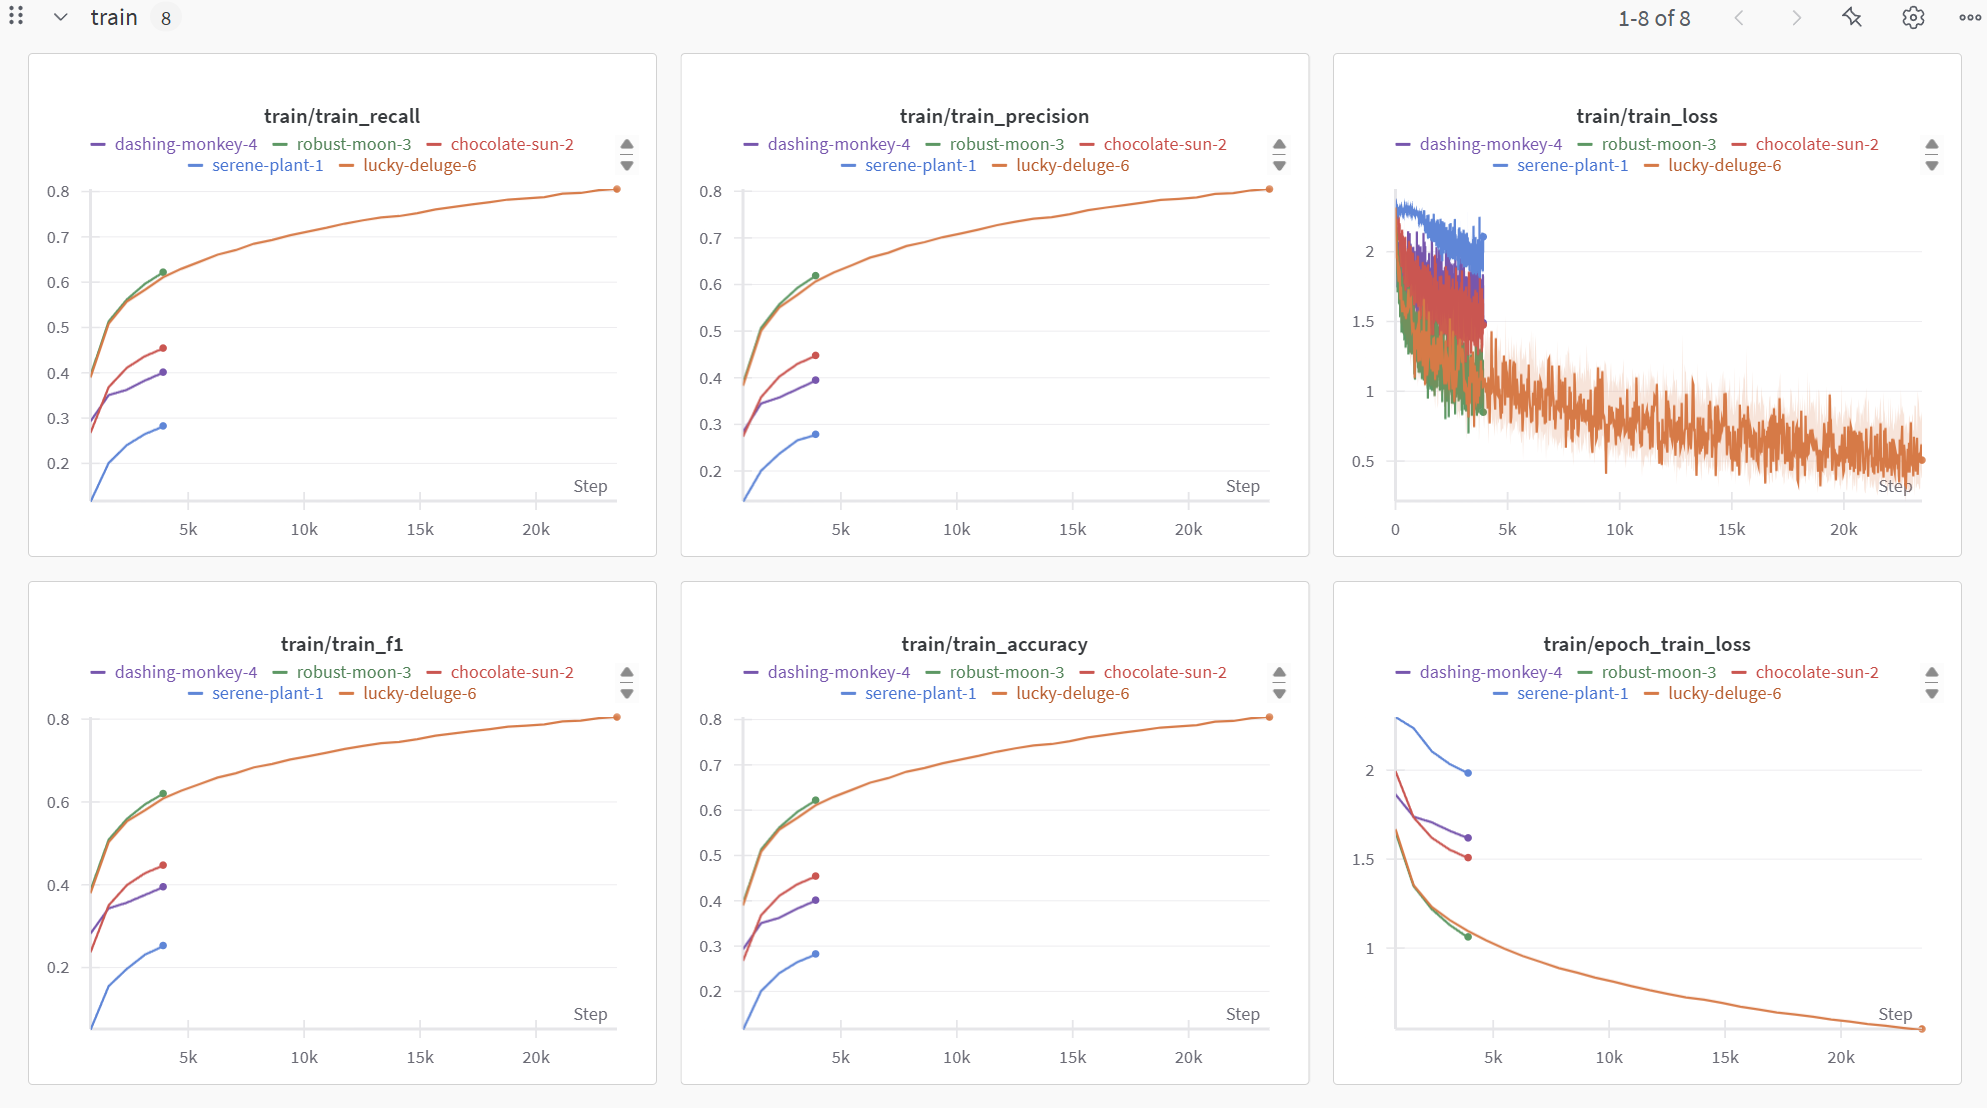

## Val Plots
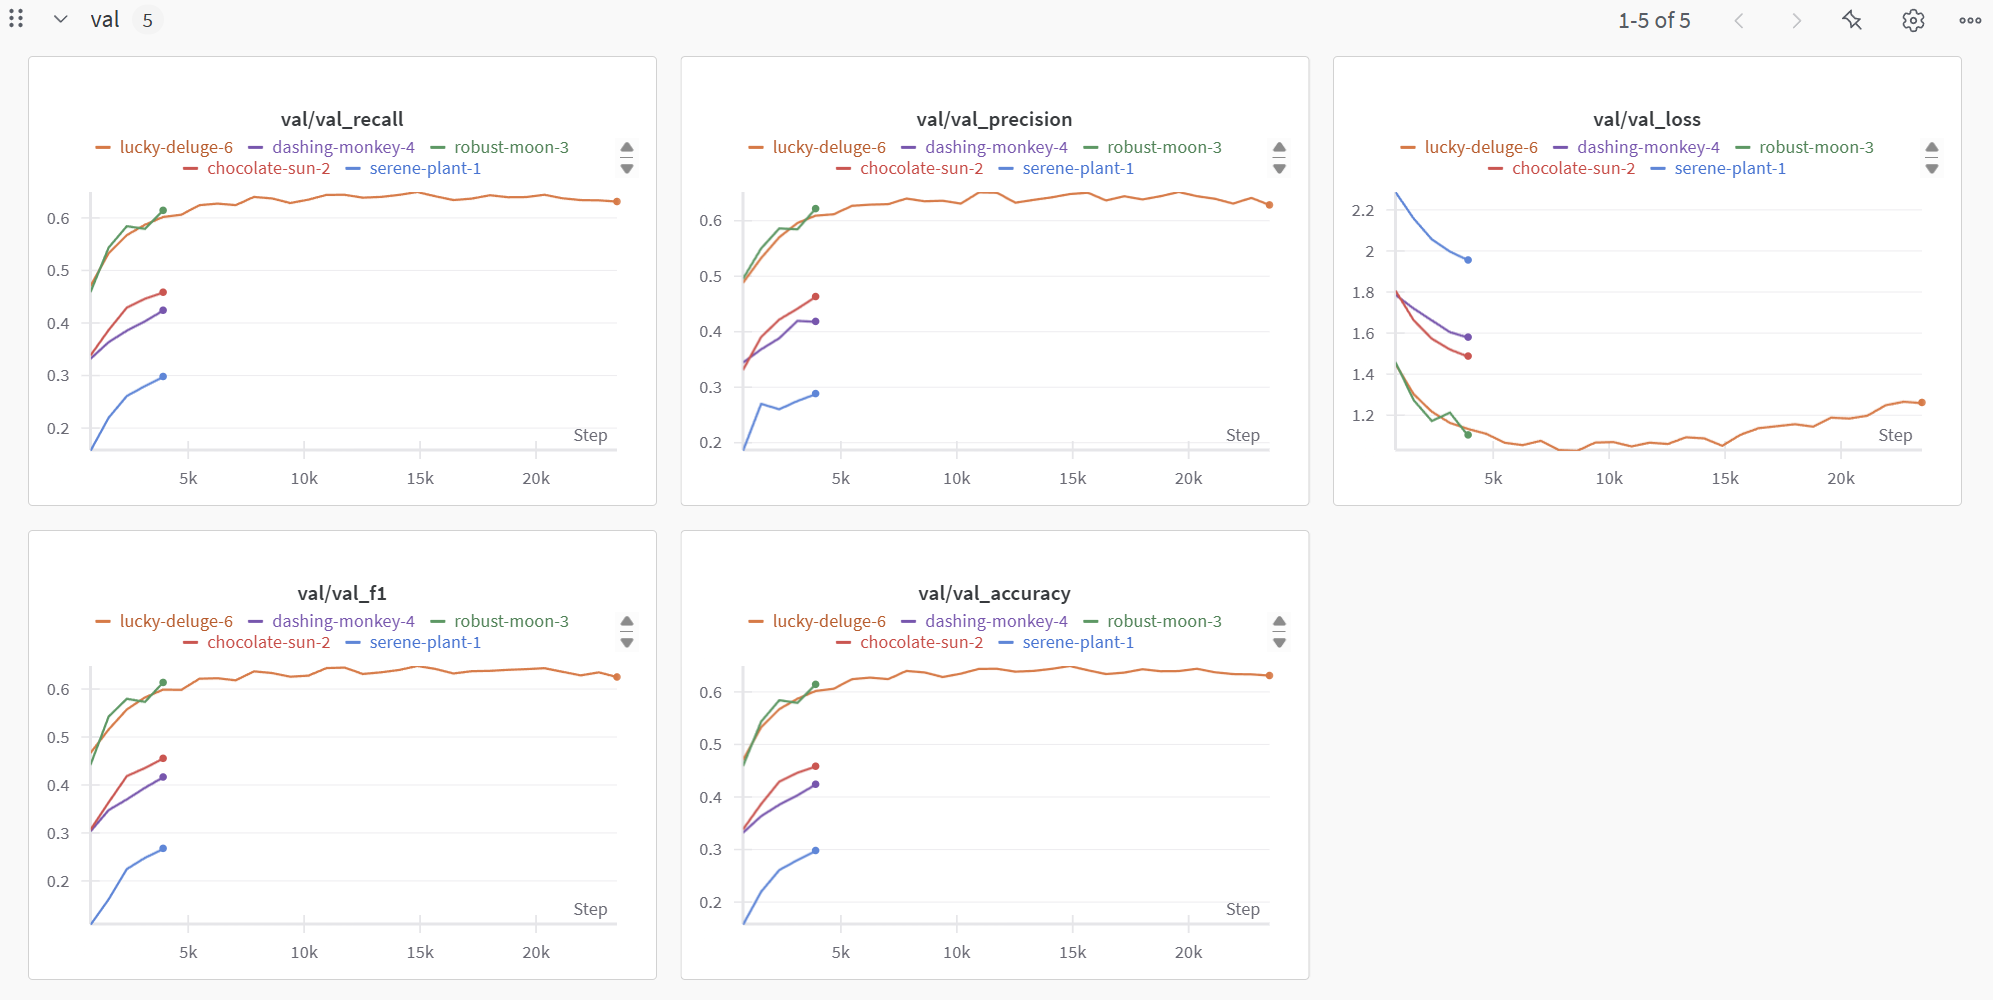

---